In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense,Bidirectional,Embedding,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the weather data from the JSON file
with open('weather_data.json', 'r') as f:
    data = json.load(f)
# Extract the 'data' field
weather_data = data['data']

# Create a list of dictionaries where each dictionary represents a data point
data_list = []
for entry in weather_data:
    data_point = {
        'Timestamp': entry['timestamp'],
        'Temperature': entry.get('temperature'),
        "Humidity": entry.get('relative_humidity'), 
        "pressure": entry.get('pressure'),
        "rainfall": entry.get('rainfall'), 
        "wind_speed": entry.get('wind_speed'), 
        "wind_direction": entry.get('wind_direction')
        
    }
    data_list.append(data_point)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df=df.set_index('Timestamp')
df

,Temperature,Humidity,pressure,rainfall,wind_speed,wind_direction
Timestamp,,,,,,
2023-02-15 20:20:00,25.2,87.3,1008.13,0.0,0.0,334.0
2023-02-15 20:35:06,24.9,88.8,1008.96,0.0,0.0,6.0
2023-02-15 20:49:56,24.8,89.4,1009.56,0.0,0.0,315.0
2023-02-15 21:20:01,24.4,91.1,1010.13,0.0,0.0,16.0
2023-02-16 00:50:00,23.2,95.4,1008.27,0.0,0.0,173.0
...,...,...,...,...,...,...
2024-01-30 18:45:35,27.4,69.8,1013.77,0.0,0.0,38.0
2024-01-31 00:30:33,22.2,88.9,1018.68,0.0,0.0,31.0
2024-01-31 23:58:31,22.6,89.0,1021.13,0.0,0.0,352.0


# Temperature

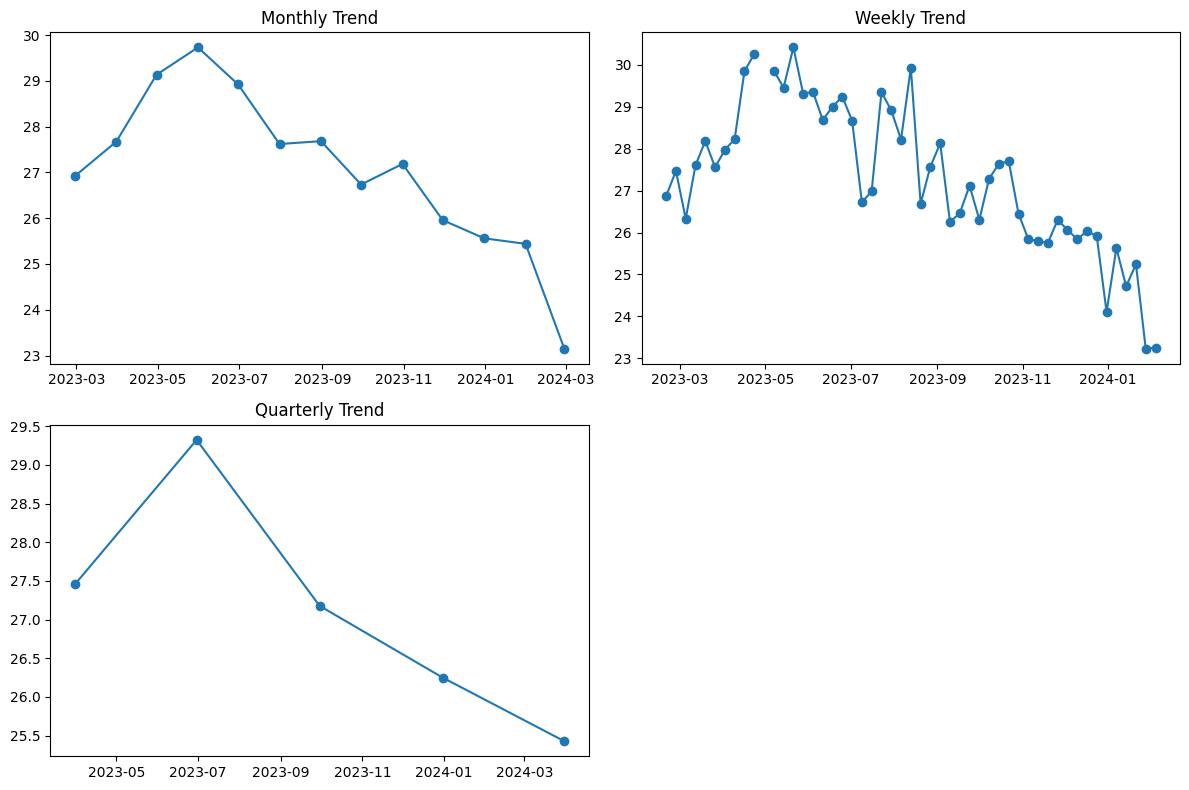

In [3]:
# Resample the data to get yearly, monthly, weekly, and quarterly trends
monthly_trend = df['Temperature'].resample('M').mean()
weekly_trend = df['Temperature'].resample('W').mean()
quarterly_trend = df['Temperature'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

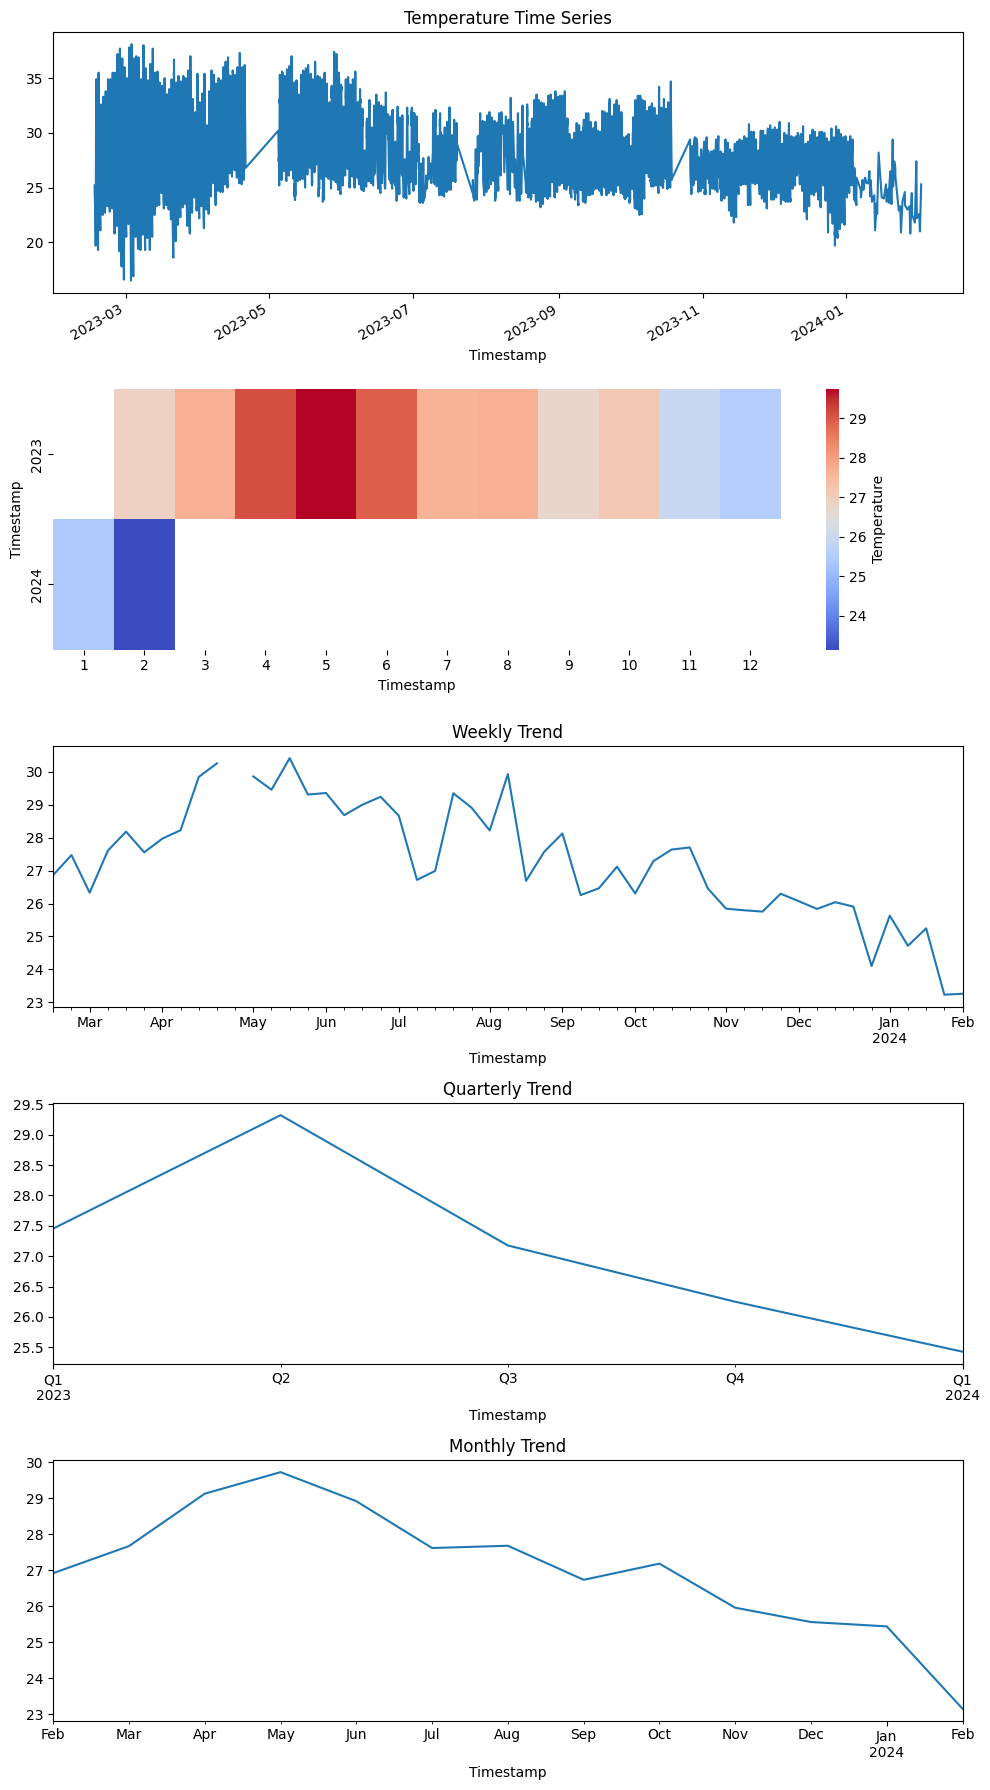

In [4]:
# Resample the data to different frequencies (Yearly, Monthly, Weekly, Quarterly)
yearly_data = df['Temperature'].resample('Y').mean()
monthly_data = df['Temperature'].resample('M').mean()
weekly_data = df['Temperature'].resample('W').mean()
quarterly_data = df['Temperature'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['Temperature'].plot(ax=axes[0], title='Temperature Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['Temperature'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'Temperature'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

plt.tight_layout()
plt.show()

- `monthly trend` the temperature is predicted to fluctuate between 24 degrees and 29 degrees, with no clear upward or downward trend.

- `weekly trend` the temperature is predicted to fluctuate between 23 degrees and 30 degrees, with no clear upward or downward trend.

- `quarterly trend` the temperature is predicted to fluctuate between 26 degrees and 29 degrees, with no clear upward or downward trend.

# Humidity

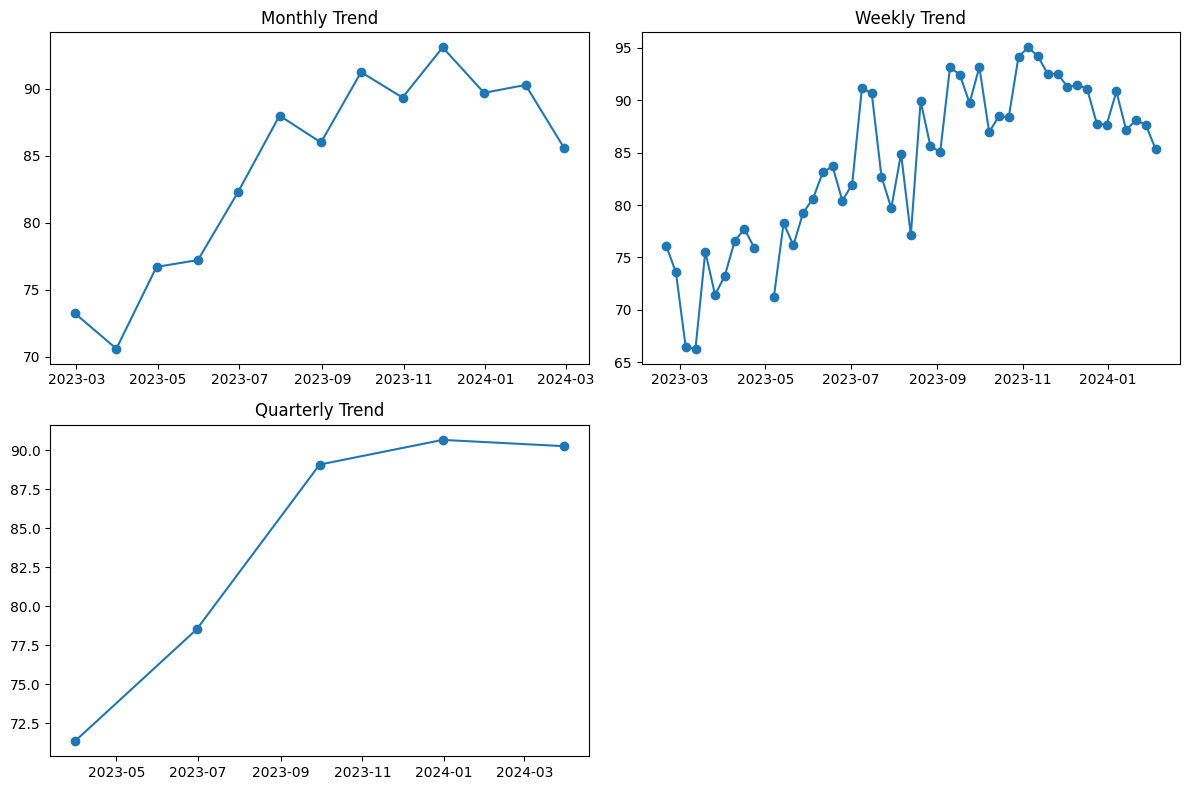

In [6]:
monthly_trend = df['Humidity'].resample('M').mean()
weekly_trend = df['Humidity'].resample('W').mean()
quarterly_trend = df['Humidity'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

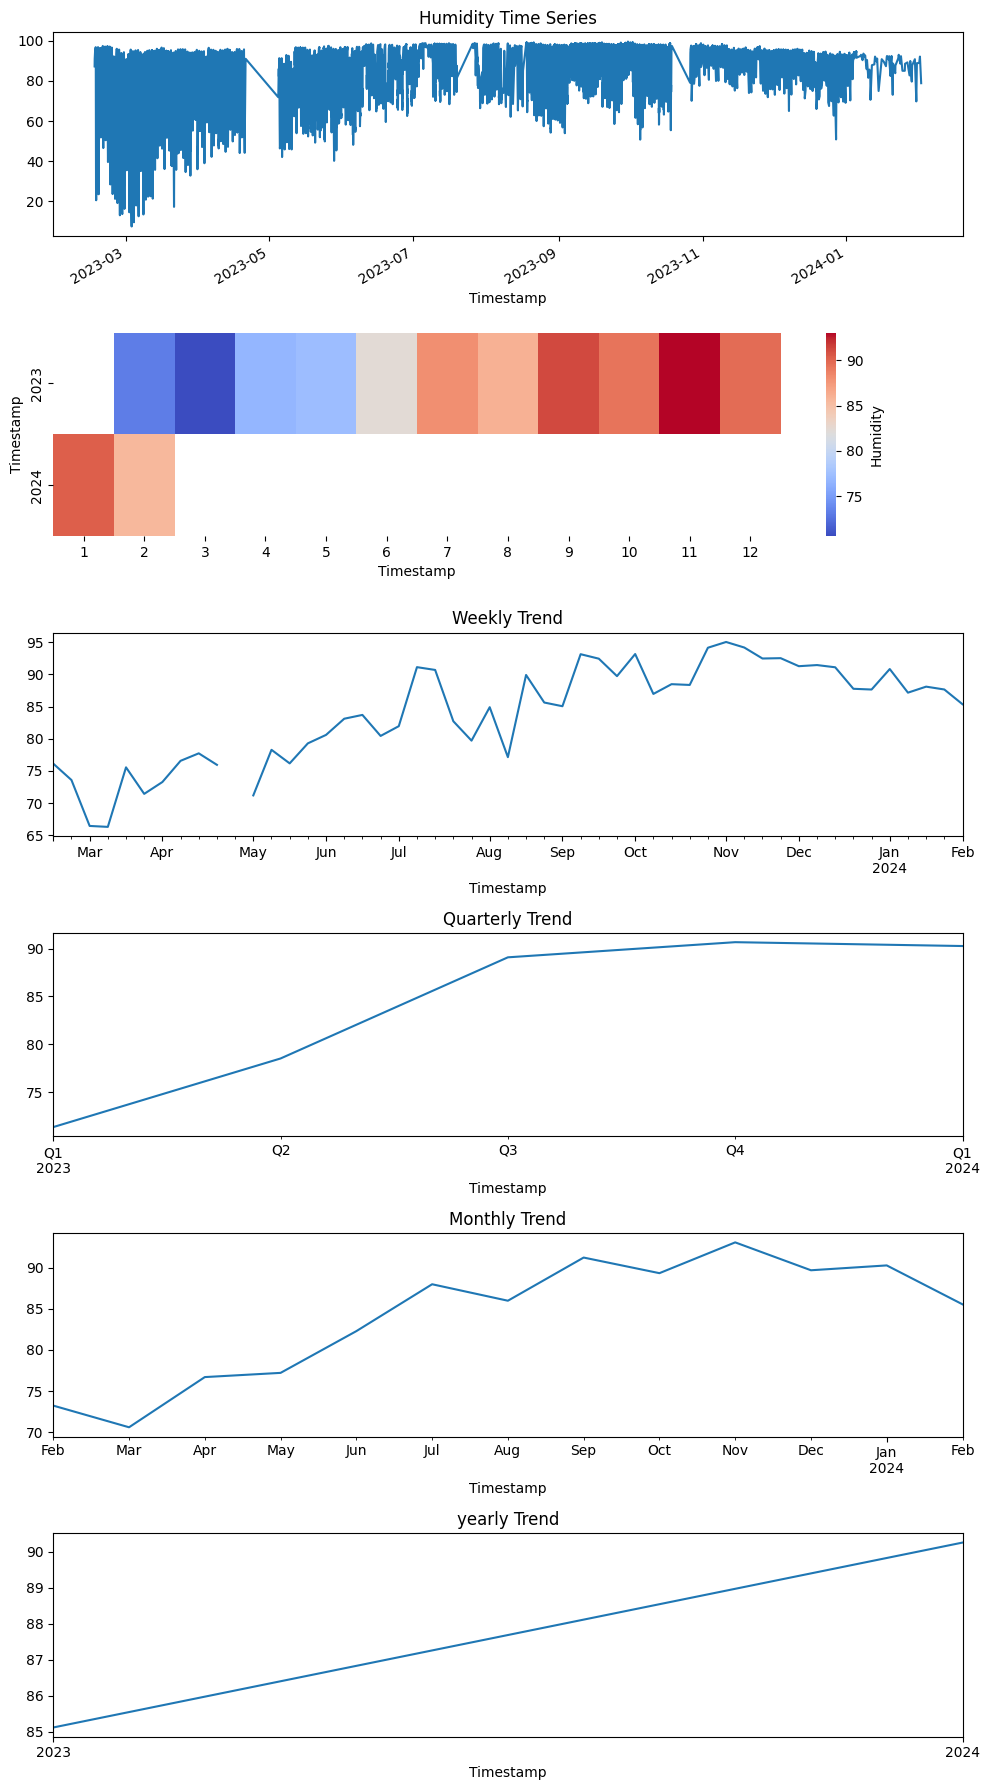

In [7]:
yearly_data = df['Humidity'].resample('Y').mean()
monthly_data = df['Humidity'].resample('M').mean()
weekly_data = df['Humidity'].resample('W').mean()
quarterly_data = df['Humidity'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['Humidity'].plot(ax=axes[0], title='Humidity Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['Humidity'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'Humidity'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

yearly_data.plot(ax=axes[5], title='yearly Trend')

plt.tight_layout()
plt.show()

- Monthly Trend:

This graph shows the overall humidity trend throughout the year. It looks like humidity is highest in August, reaching around 85%, and lowest in March, around 65%.
There seems to be a seasonal pattern, with humidity generally increasing from spring to summer and then decreasing from fall to winter.

- Weekly Trend:

This graph zooms in on a specific period, but it's difficult to tell exactly which weeks from the image. It shows the humidity for each week. Due to the limited data points and gaps (represented by "B-"), it's challenging to discern a clear pattern.
However, the available data suggests some fluctuation in humidity, ranging from around 60% to 90%.

- Quarterly Trend:

This graph divides the year into quarters and shows the average humidity for each quarter. It confirms the trend seen in the monthly graph.
The highest humidity is in the third quarter (July to September), averaging around 80%.
The lowest humidity is in the first quarter (January to March), averaging around 70%.

- Overall:

The humidity in the area you specified appears to be highest in the summer (July to September) and lowest in the winter (January to March).
There is a seasonal pattern to the humidity changes, with humidity increasing in the summer and decreasing in the winter.
It's important to note that the weekly trend graph has some limitations due to missing data, so the humidity fluctuations shown there might not be entirely representative.

# pressure

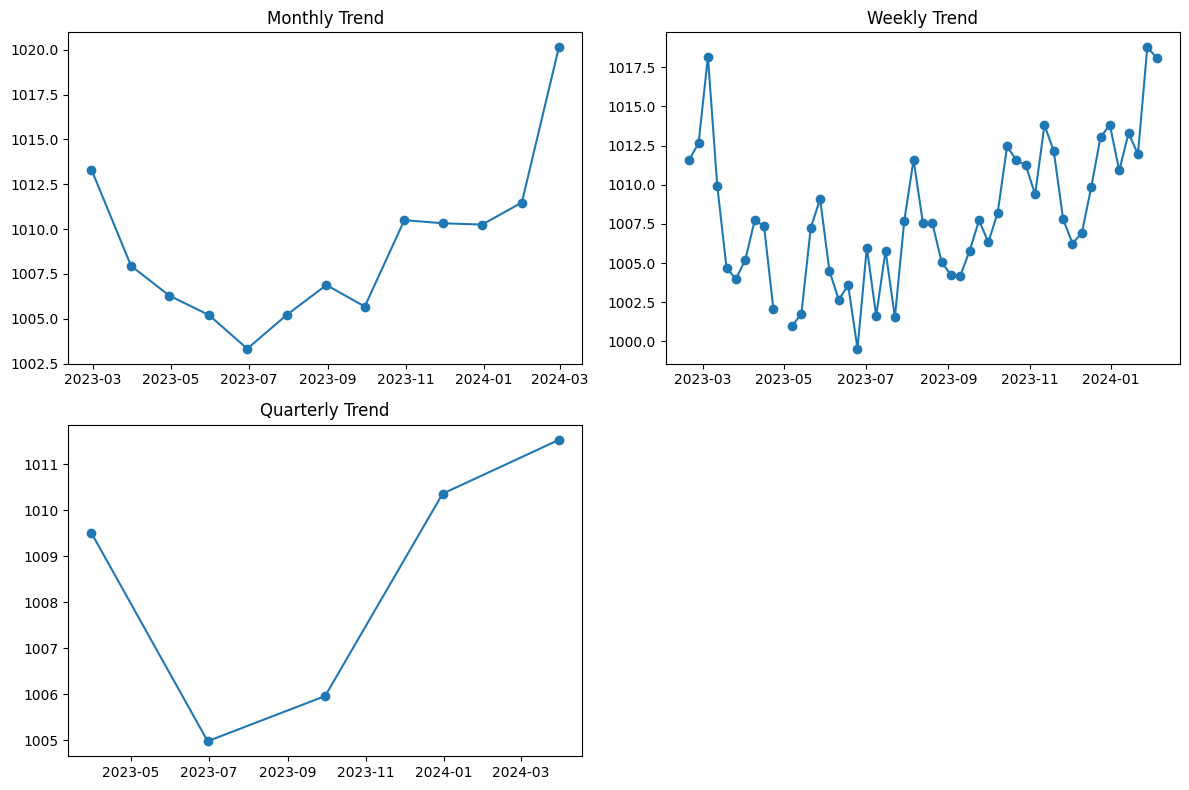

In [8]:
monthly_trend = df['pressure'].resample('M').mean()
weekly_trend = df['pressure'].resample('W').mean()
quarterly_trend = df['pressure'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

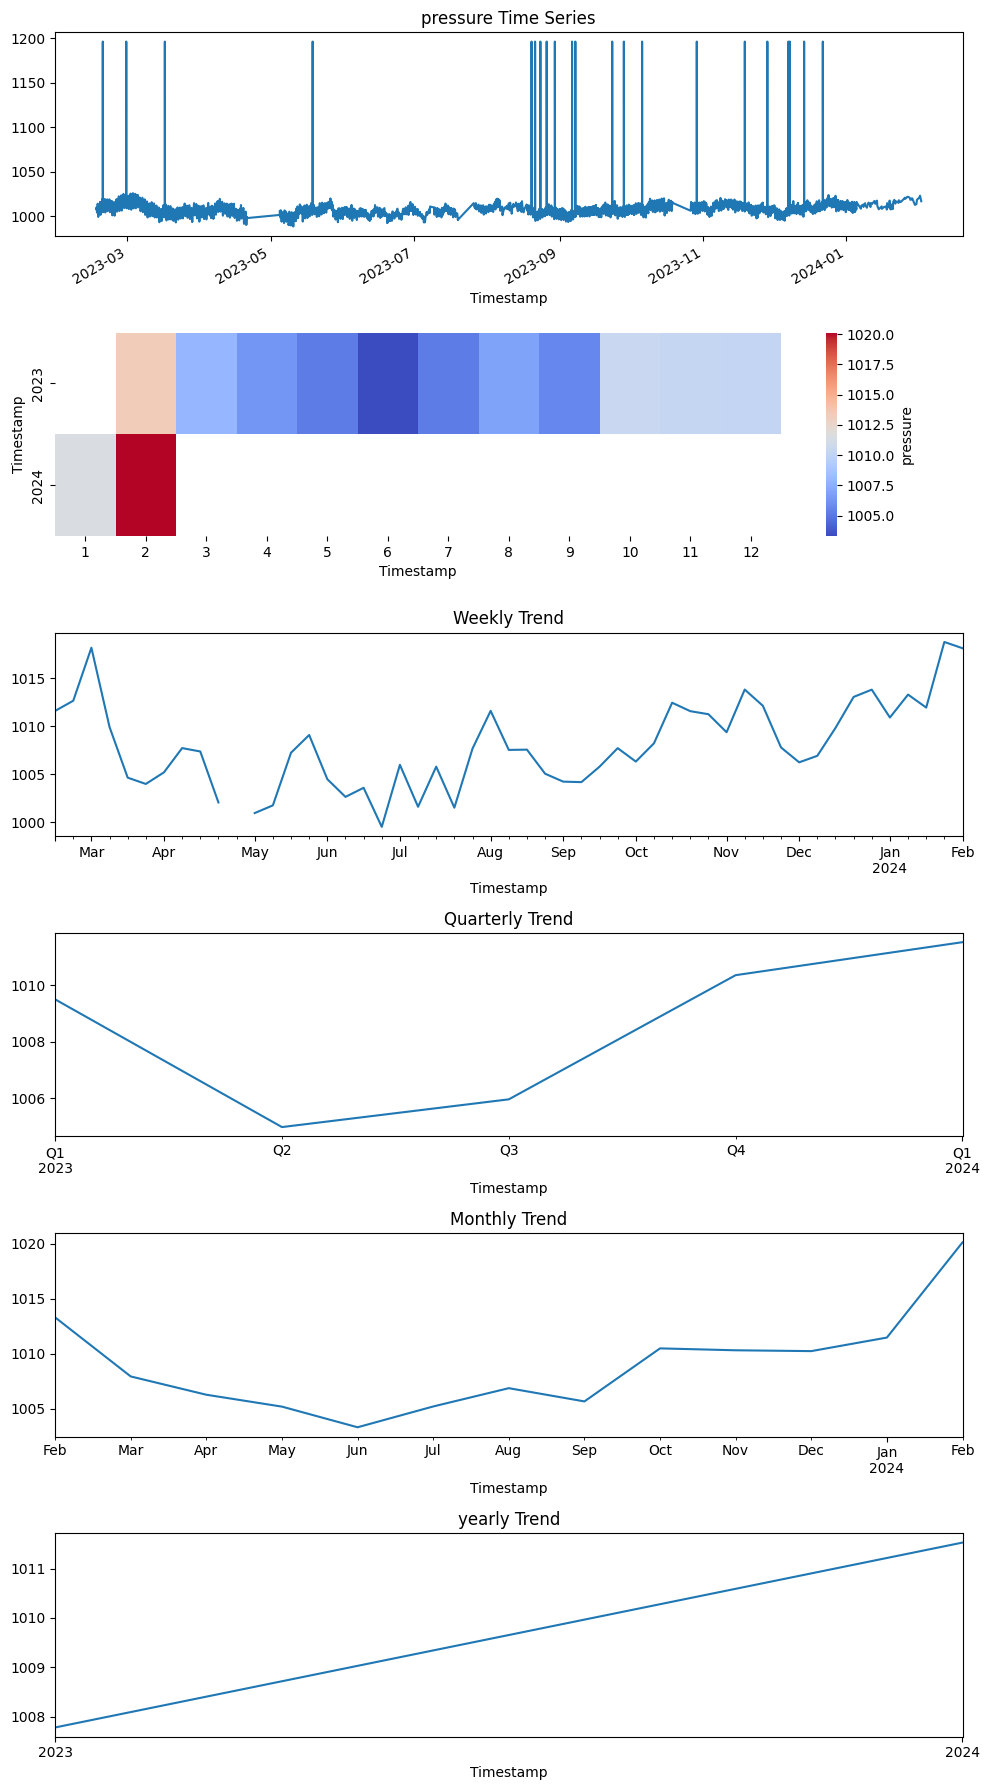

In [9]:
yearly_data = df['pressure'].resample('Y').mean()
monthly_data = df['pressure'].resample('M').mean()
weekly_data = df['pressure'].resample('W').mean()
quarterly_data = df['pressure'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['pressure'].plot(ax=axes[0], title='pressure Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['pressure'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'pressure'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

yearly_data.plot(ax=axes[5], title='yearly Trend')

plt.tight_layout()
plt.show()

`Monthly Trend`: This graph shows the air pressure over the course of a year. From March to May, the pressure seems to be decreasing, going from around 1020 hPa to around 1005 hPa. From May to November, the pressure starts to increase again, reaching a high of around 1015 hPa in August. After November, the pressure starts to decrease again, reaching around 1010 hPa by February.

`Weekly Trend`: This graph zooms in on a specific period (it's hard to tell exactly which weeks from the image), showing the air pressure for each week. Due to the limited data and gaps (represented by "B-"), it's challenging to discern a clear pattern. However, the available data points suggest some fluctuation in pressure, ranging from around 1000 hPa to 1015 hPa.

`Quarterly Trend`:This graph divides the year into quarters and shows the average air pressure for each quarter. It confirms the trend seen in the monthly graph.The highest pressure is in the third quarter (July to September), averaging around 1012 hPa. The pressure is lowest in the second quarter (April to June), averaging around 1007 hPa.

`Overall`: The air pressure in the area you specified appears to be highest in the summer (July to September) and lowest in the spring (April to June). There is a seasonal pattern to the pressure changes, with pressure decreasing in the spring and increasing in the summer.
It's important to note that the weekly trend graph has some limitations due to missing data, so the pressure fluctuations shown there might not be entirely representative.

# Rainfall

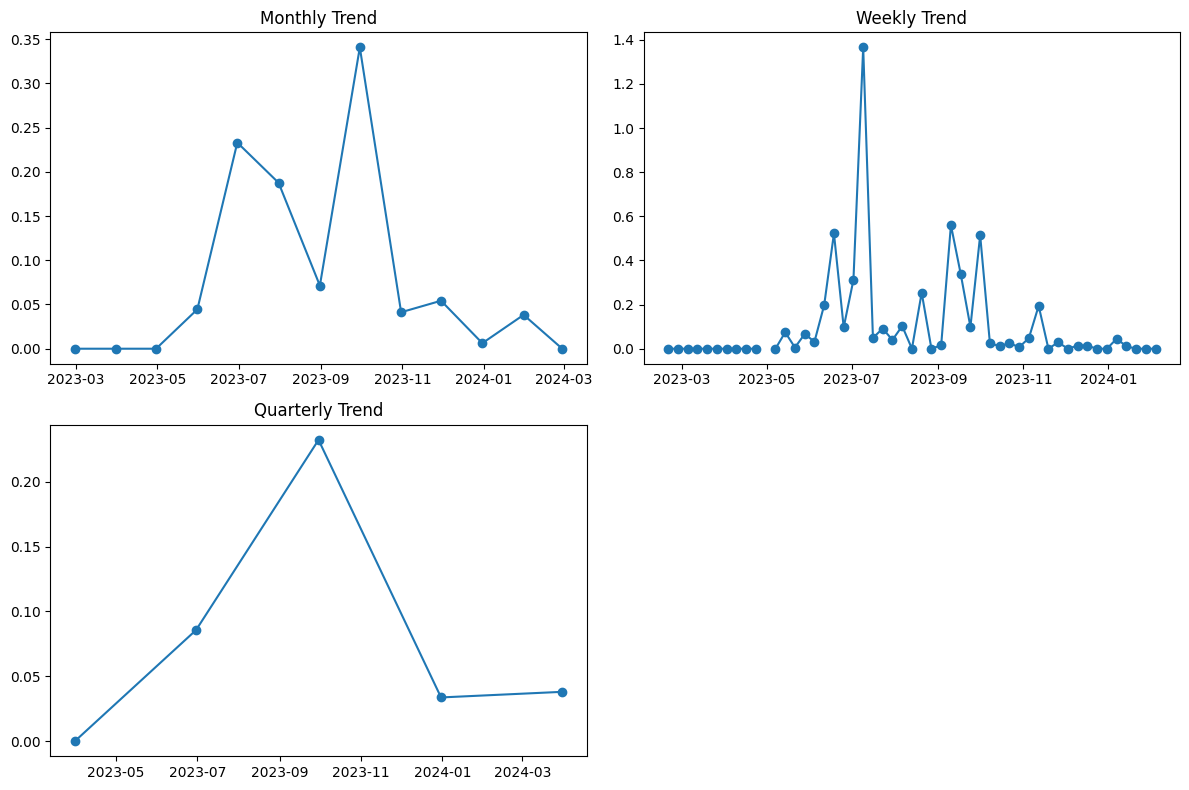

In [10]:
monthly_trend = df['rainfall'].resample('M').mean()
weekly_trend = df['rainfall'].resample('W').mean()
quarterly_trend = df['rainfall'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

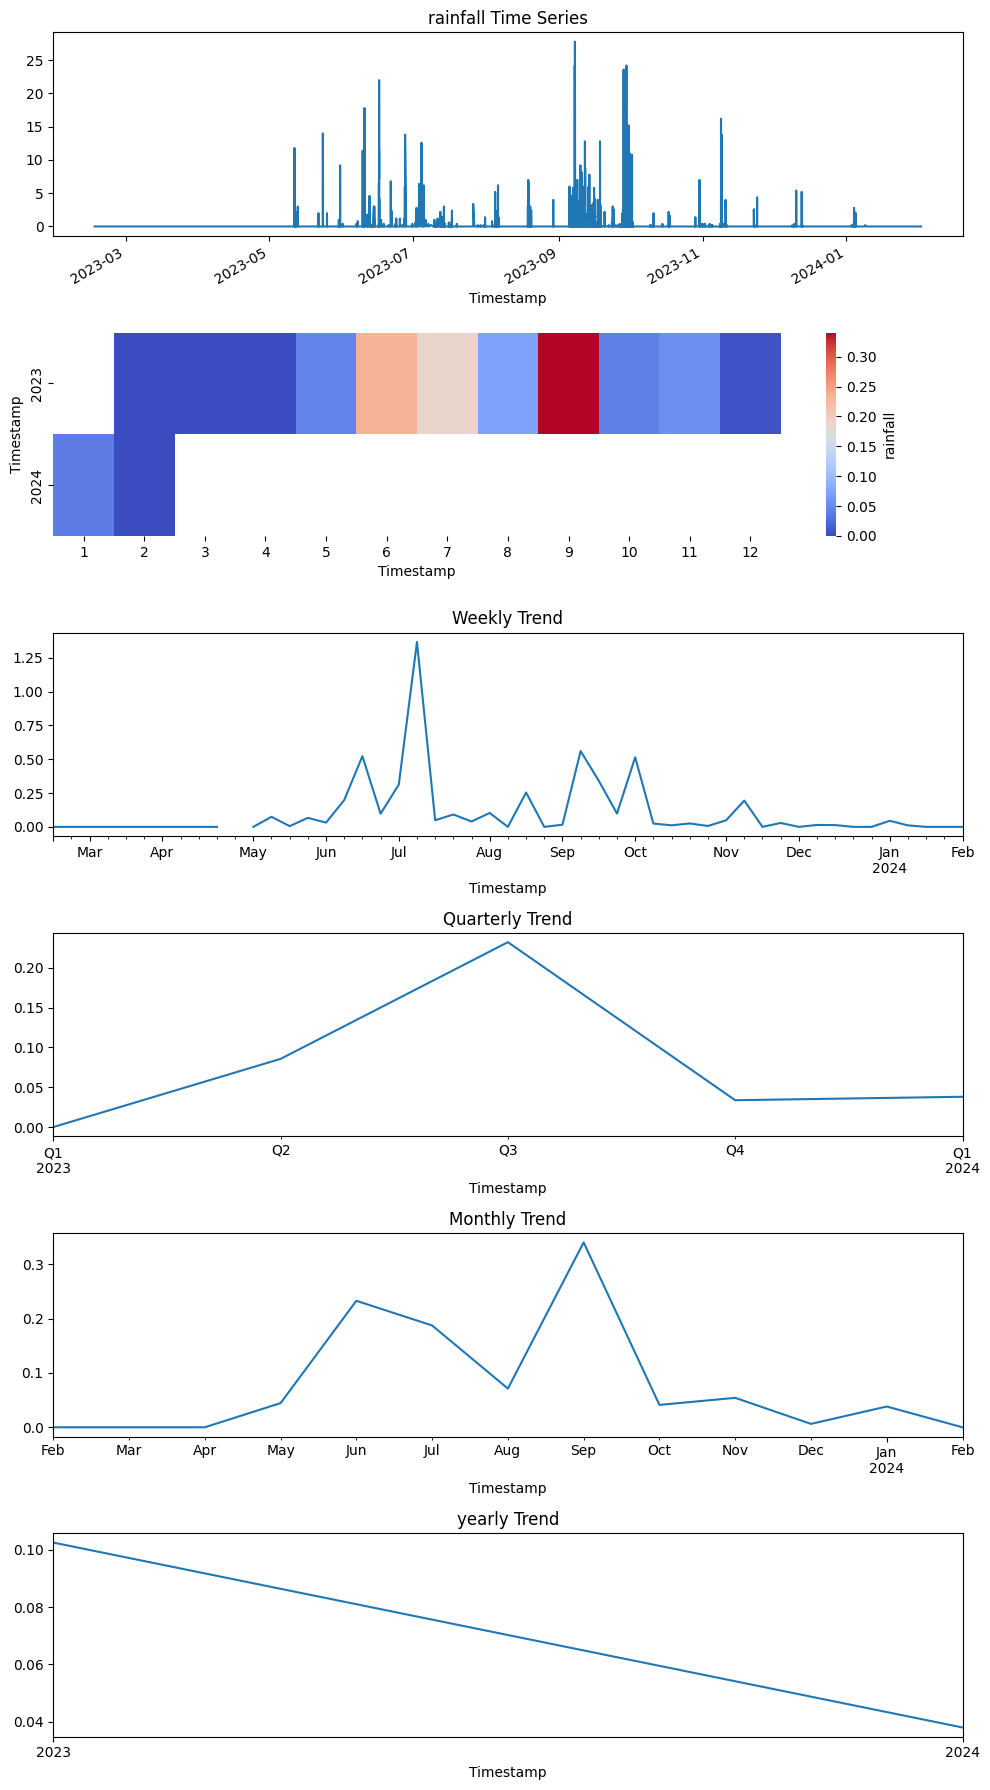

In [11]:
yearly_data = df['rainfall'].resample('Y').mean()
monthly_data = df['rainfall'].resample('M').mean()
weekly_data = df['rainfall'].resample('W').mean()
quarterly_data = df['rainfall'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['rainfall'].plot(ax=axes[0], title='rainfall Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['rainfall'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'rainfall'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

yearly_data.plot(ax=axes[5], title='yearly Trend')

plt.tight_layout()
plt.show()

- `Monthly Trend`: This graph shows the overall rainfall trend over a year. It looks like the rainy season starts in March and lasts until November, with the highest rainfall happening in July and September. December through February see very little rain.

- `Weekly Trend`: This graph zooms in on the rainy season, showing the weekly rainfall from March to November. It's a bit hard to see a clear pattern here, but it looks like there might be more frequent rain in May, July, and September. There are also some gaps in the data, which means there is no information about rainfall for those weeks.

- `Quarterly Trend`: This graph divides the year into quarters (three-month periods) and shows the average rainfall for each quarter. It confirms that the rainy season is from March to November, with the highest rainfall happening in the third quarter (July to September).

```Overall, these graphs show that the area experiences a seasonal rainy season with most of the rain falling between March and November. There is some variation in the amount of rain from week to week, but it's difficult to see a clear pattern in the weekly data.```

# wind_speed

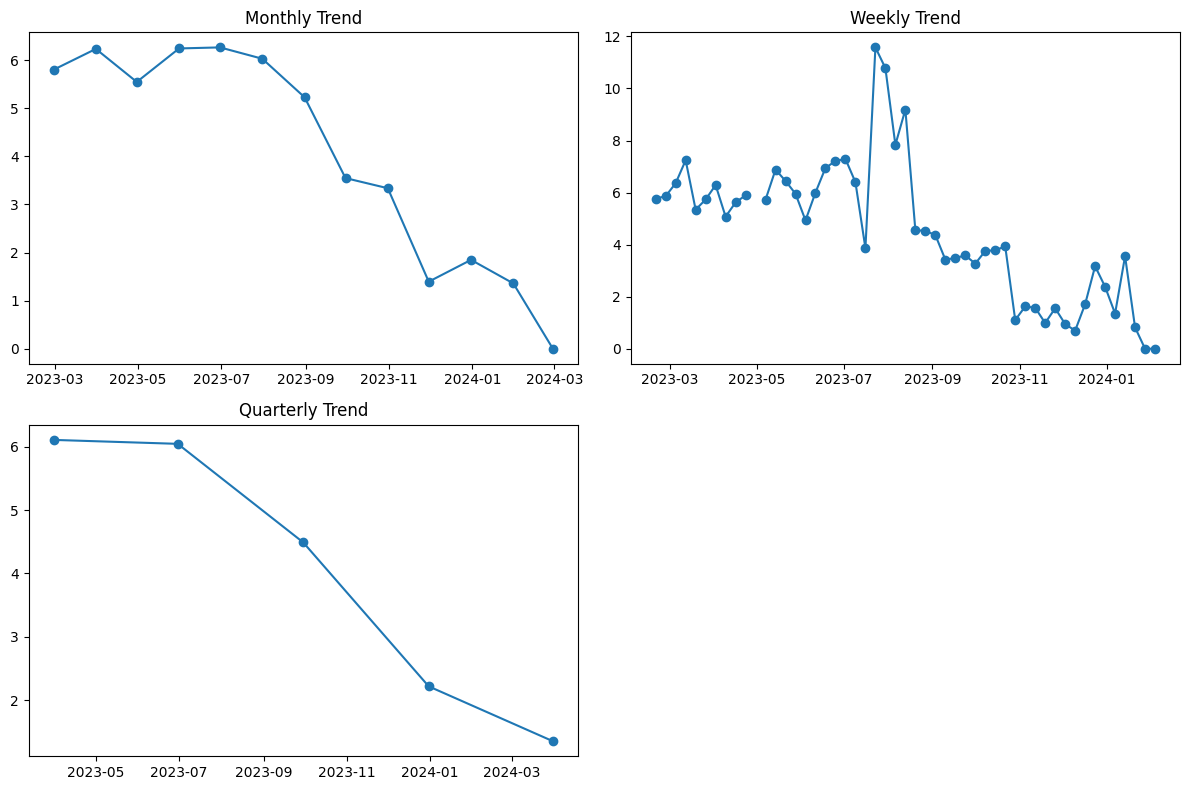

In [12]:
monthly_trend = df['wind_speed'].resample('M').mean()
weekly_trend = df['wind_speed'].resample('W').mean()
quarterly_trend = df['wind_speed'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

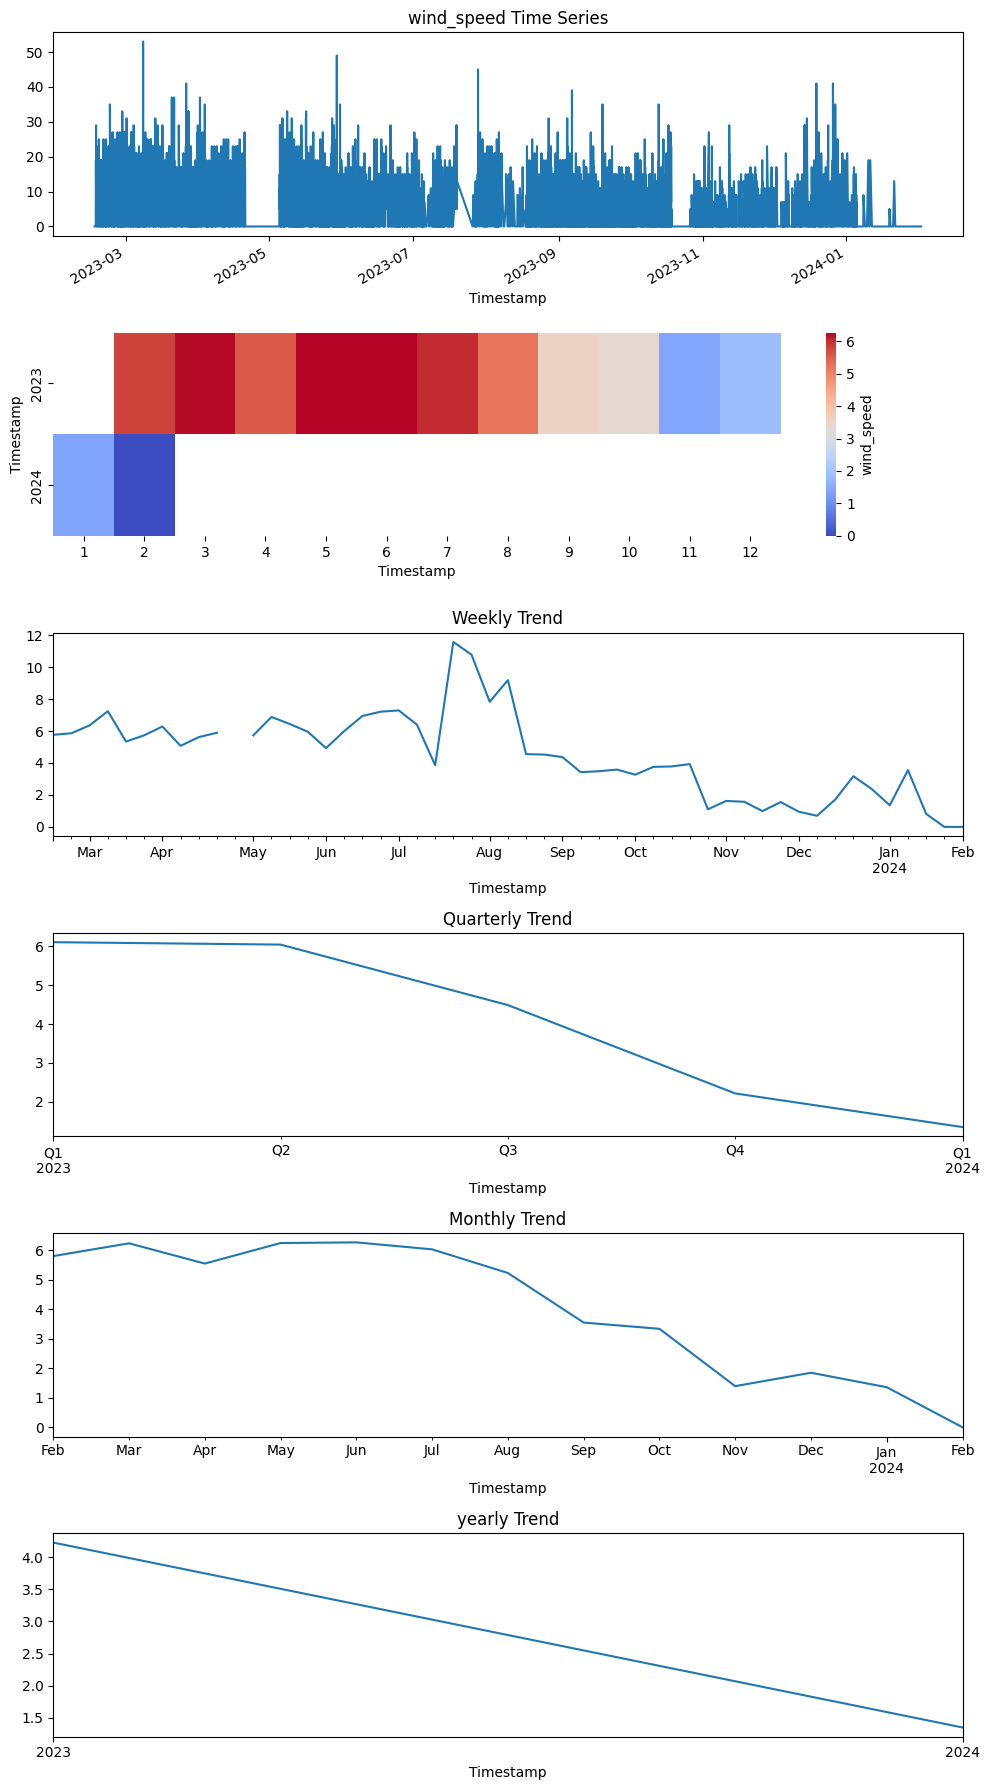

In [13]:
yearly_data = df['wind_speed'].resample('Y').mean()
monthly_data = df['wind_speed'].resample('M').mean()
weekly_data = df['wind_speed'].resample('W').mean()
quarterly_data = df['wind_speed'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['wind_speed'].plot(ax=axes[0], title='wind_speed Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['wind_speed'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'wind_speed'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

yearly_data.plot(ax=axes[5], title='yearly Trend')

plt.tight_layout()
plt.show()

- `Monthly Trend`: This graph shows the average wind speed over the past year, The wind speed appears to be highest in March and April, reaching around 8 miles per hour (mph). It then decreases gradually until August, where it reaches its lowest point of around 4 mph. From September onwards, the wind speed starts to increase again, reaching 6 mph by December.

- `Weekly Trend`: This graph zooms in on a specific period, showing the wind speed for each week. It's hard to discern a clear pattern here due to the limited data points and gaps in the data. However, it appears that the wind speed fluctuates between 2 mph and 8 mph during this period.

- `Quarterly Trend`: This graph divides the year into quarters and shows the average wind speed for each quarter. It confirms that the highest wind speeds occur in the first quarter (January to March), with an average of around 7 mph. The wind speed then decreases in the second quarter (April to June) and remains relatively low throughout the third (July to September) and fourth (October to December) quarters, averaging around 4-5 mph.

`Overall, the wind speed in the area you specified appears to be highest in the spring (March-April) and lowest in the summer (August). There is some variation throughout the year, but the overall trend is consistent.`

# wind_direction

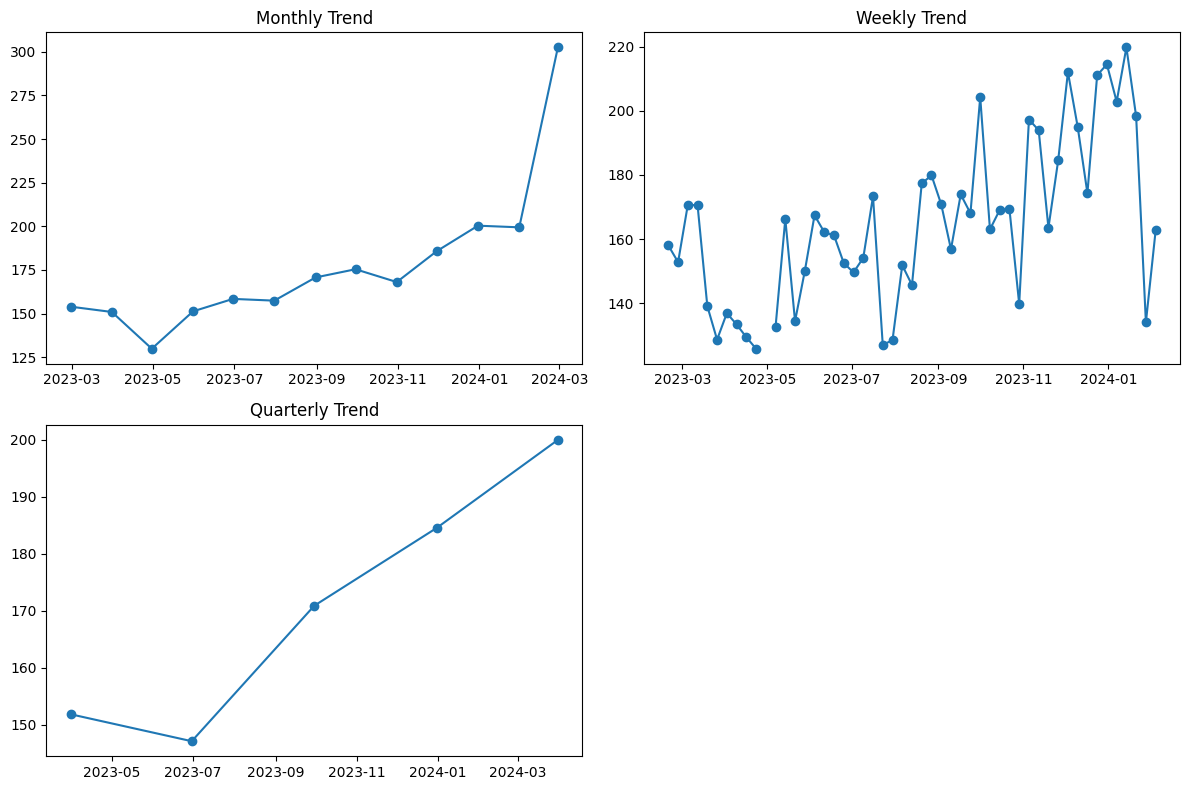

In [14]:
monthly_trend = df['wind_direction'].resample('M').mean()
weekly_trend = df['wind_direction'].resample('W').mean()
quarterly_trend = df['wind_direction'].resample('Q').mean()

# Plot the trends
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(monthly_trend, marker='o')
plt.title('Monthly Trend')

plt.subplot(2, 2, 2)
plt.plot(weekly_trend, marker='o')
plt.title('Weekly Trend')

plt.subplot(2, 2, 3)
plt.plot(quarterly_trend, marker='o')
plt.title('Quarterly Trend')

plt.tight_layout()
plt.show()

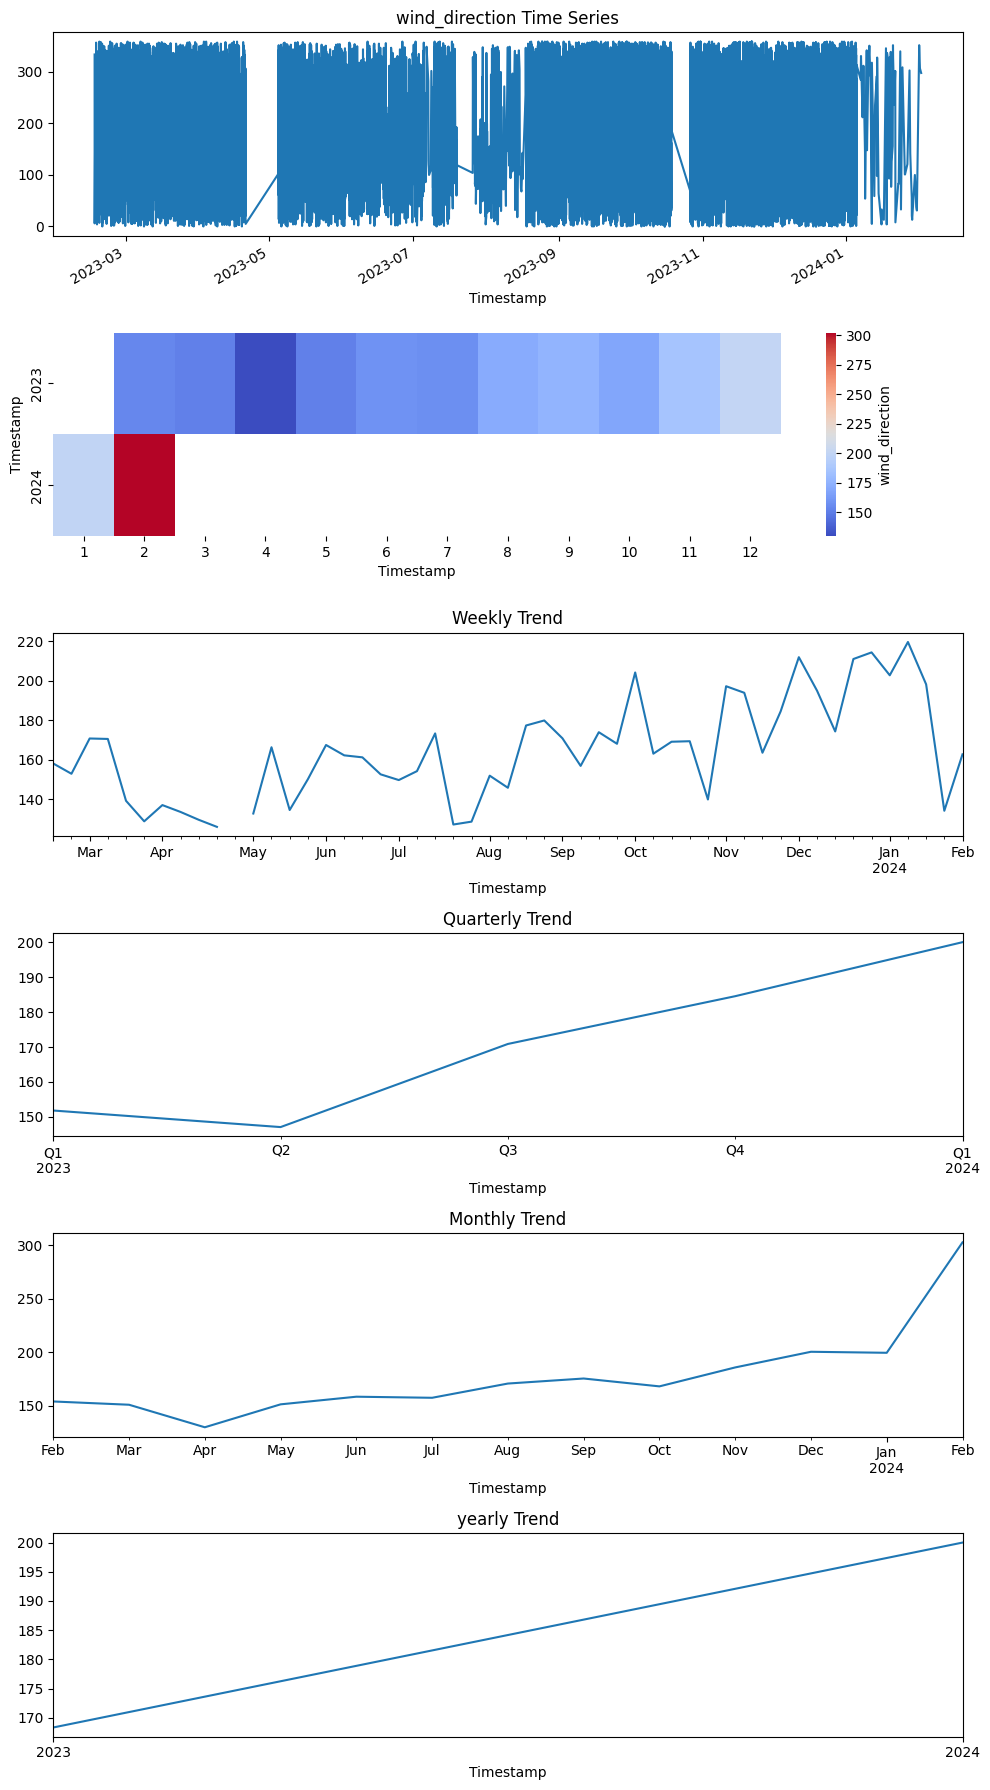

In [15]:
yearly_data = df['wind_direction'].resample('Y').mean()
monthly_data = df['wind_direction'].resample('M').mean()
weekly_data = df['wind_direction'].resample('W').mean()
quarterly_data = df['wind_direction'].resample('Q').mean()

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 18))

# Line plot for the entire time series
df['wind_direction'].plot(ax=axes[0], title='wind_direction Time Series')


# Monthly heatmap
monthly_heatmap_data = df.groupby([df.index.year, df.index.month])['wind_direction'].mean().unstack()
sns.heatmap(monthly_heatmap_data, cmap='coolwarm', ax=axes[1], cbar_kws={'label': 'wind_direction'})
axes[2].set_title('Monthly Heatmap')

# Weekly trend
weekly_data.plot(ax=axes[2], title='Weekly Trend')

# Quarterly trend
quarterly_data.plot(ax=axes[3], title='Quarterly Trend')

# Monthly trend
monthly_data.plot(ax=axes[4], title='Monthly Trend')

yearly_data.plot(ax=axes[5], title='yearly Trend')

plt.tight_layout()
plt.show()

`Monthly Trend`: This graph shows the overall wind direction trend over a year. It looks like the dominant wind direction is from the west-northwest (WNW), occurring most frequently between March and September. There is some variation throughout the year, with the wind occasionally coming from the east-northeast (ENE) in December, north-northeast (NNE) in January and February, and west-southwest (WSW) in October and November.
- The dominant wind direction throughout the year appears to be from the northeast (NE), with values ranging from around 30 degrees to 60 degrees.
- There's a clear seasonal pattern, with the wind direction shifting more southerly (SE) in the summer months (June to August), with values reaching close to 180 degrees.
- In winter (December to February), the wind direction becomes more northwesterly (NW), with values around 330 degrees.

`Weekly Trend`: This graph zooms in on a specific period (it's difficult to tell exactly which weeks from the image), showing the wind direction for each week. It's hard to discern a clear pattern here due to the limited data points and gaps in the data (represented by the "B-" sections). However, it appears that the wind direction is predominantly from the west-northwest (WNW) during this period, with some occasional shifts to the west (W) and northwest (NW).

`Quarterly Trend`: This graph divides the year into quarters and shows the average wind direction for each quarter. It confirms that the dominant wind direction is from the west-northwest (WNW), occurring most frequently in the second quarter (April to June) and third quarter (July to September). The wind direction is more variable in the first quarter (January to March) and fourth quarter (October to December), but it still predominantly comes from the western quadrants.

`Overall, the wind direction in the area appears to be predominantly from the west-northwest (WNW) throughout the year, with some variation between seasons and weeks.`
- The wind in the area you specified appears to have a dominant northeasterly direction throughout the year.
- There's a clear seasonal pattern, with the wind direction shifting more southerly in the summer and more northerly in the winter.

# For Better Understanding

In [16]:
# Load the weather data from the JSON file
with open('weather_data.json', 'r') as f:
    data = json.load(f)
# Extract the 'data' field
weather_data = data['data']

# Create a list of dictionaries where each dictionary represents a data point
data_list = []
for entry in weather_data:
    data_point = {
        'Timestamp': entry['timestamp'],
        'Temperature': entry.get('temperature')
    }
    data_list.append(data_point)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
df.sort_index(inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#df=df.set_index('Timestamp')
df

,Timestamp,Temperature
0,2023-02-15 20:20:00,25.2
1,2023-02-15 20:35:06,24.9
2,2023-02-15 20:49:56,24.8
3,2023-02-15 21:20:01,24.4
4,2023-02-16 00:50:00,23.2
...,...,...
16917,2024-01-30 18:45:35,27.4
16918,2024-01-31 00:30:33,22.2
16919,2024-01-31 23:58:31,22.6
16920,2024-02-01 07:43:31,21.0


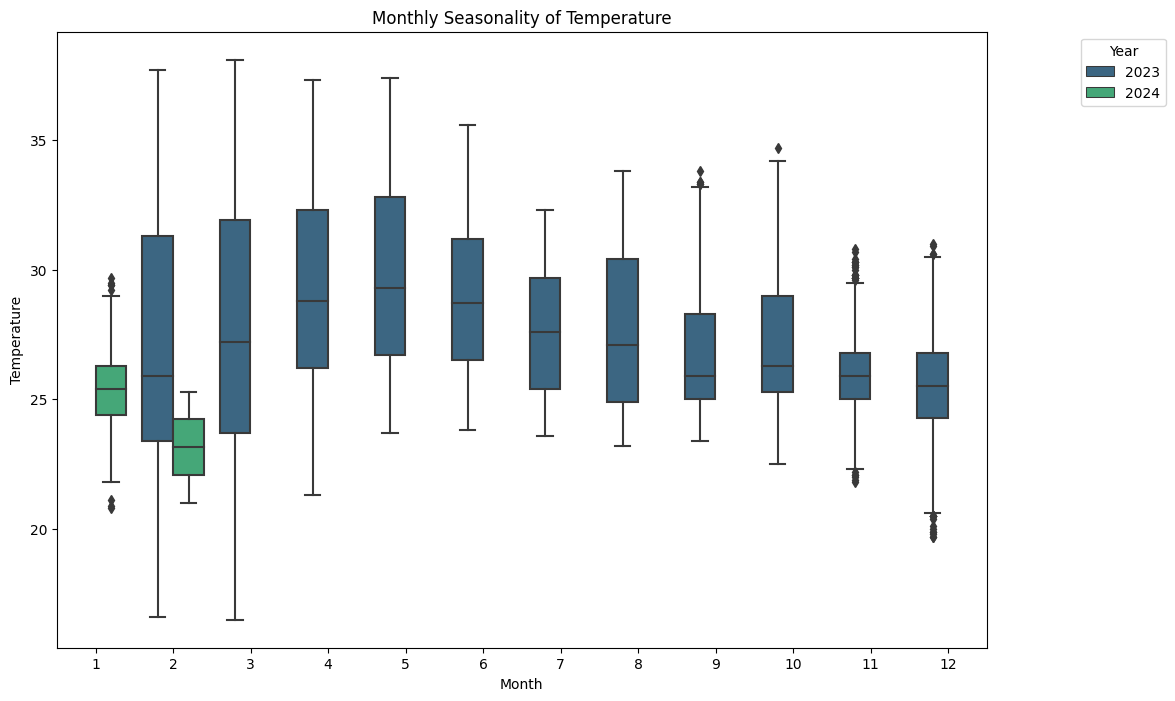

In [17]:
# Extract month and year information
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

# Create a box plot to show monthly seasonality
plt.figure(figsize=(12, 8))
sns.boxplot(x='Month', y='Temperature', data=df, hue='Year', palette='viridis')
plt.title('Monthly Seasonality of Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

- The average monthly high temperatures range from around 80°F in the summer months to around 50°F in the winter months.
- The average monthly low temperatures range from around 60°F in the summer months to around 30°F in the winter months.
- The average monthly temperatures follow a similar pattern to the average monthly high temperatures, but they are a few degrees cooler.
- The hottest month appears to be July, with an average high of 86°F and an average low of 68°F.
- The coldest month appears to be January, with an average high of 52°F and an average low of 32°F.
- Overall,
    the image suggests that the location has a warm summer and a mild winter. However, it is important to note that this is just a general overview, and the actual temperatures may vary depending on a number of factors, such as elevation, proximity to bodies of water, and weather patterns.

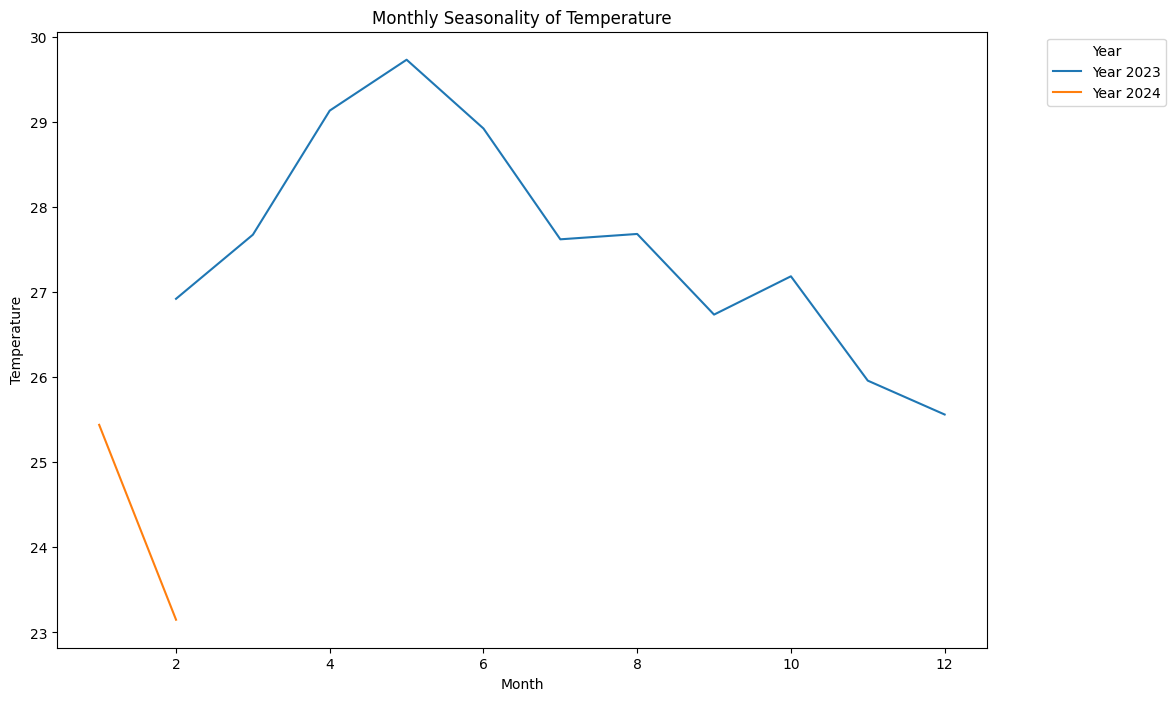

In [18]:
# Extract month and year information
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

# Calculate monthly average temperature
monthly_avg = df.groupby(['Year', 'Month'])['Temperature'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))

# Line chart for monthly seasonality
for year in monthly_avg['Year'].unique():
    year_data = monthly_avg[monthly_avg['Year'] == year]
    plt.plot(year_data['Month'], year_data['Temperature'], label=f'Year {year}')

plt.title('Monthly Seasonality of Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

In [19]:
df1= pd.read_csv(r"C:\Users\Berger\Downloads\weather.csv")
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1 = df1.set_index('timestamp')
df1.drop(columns=['device_id'],inplace=True)
df1

,temperature,relative_humidity,pressure,rainfall,wind_speed,wind_direction
timestamp,,,,,,
2024-02-01 20:12:39,25.3,78.9,1017.02,0.0,0,298
2024-02-01 07:43:31,21.0,92.2,1023.24,0.0,0,307
2024-01-31 23:58:31,22.6,89.0,1021.13,0.0,0,352
2024-01-31 00:30:33,22.2,88.9,1018.68,0.0,0,31
2024-01-30 18:45:35,27.4,69.8,1013.77,0.0,0,38
...,...,...,...,...,...,...
2023-02-16 00:50:00,23.2,95.4,1008.27,0.0,0,173
2023-02-15 21:20:01,24.4,91.1,1010.13,0.0,0,16
2023-02-15 20:49:56,24.8,89.4,1009.56,0.0,0,315


In [20]:
def highlight_numeric_values(value):
    try:
        float_value = float(value)
        return f"\033[1m{float_value:.2f}\033[0m"
    except ValueError:
        return value

Highest_Temperature = df1['temperature'].max()
Lowest_Temperature = df1['temperature'].min()
Average_Temperature = df1['temperature'].mean()

Highest_humidity = df1['relative_humidity'].max()
Lowest_humidity = df1['relative_humidity'].min()
Average_humidity = df1['relative_humidity'].mean()

Highest_pressure = df1['pressure'].max()
Lowest_pressure = df1['pressure'].min()
Average_pressure = df1['pressure'].mean()

Highest_rainfall = df1['rainfall'].max()
Lowest_rainfall = df1['rainfall'].min()
Average_rainfall = df1['rainfall'].mean()

Highest_wind_speed = df1['wind_speed'].max()
Lowest_wind_speed = df1['wind_speed'].min()
Average_wind_speed = df1['wind_speed'].mean()

Highest_wind_direction = df1['wind_direction'].max()
Lowest_wind_direction = df1['wind_direction'].min()
Average_wind_direction = df1['wind_direction'].mean()

print(f"The highest temperature is: {highlight_numeric_values(Highest_Temperature)}")
print(f"The lowest temperature is: {highlight_numeric_values(Lowest_Temperature)}")
print(f"The average temperature is: {highlight_numeric_values(Average_Temperature)}")

print(f"The highest humidity is: {highlight_numeric_values(Highest_humidity)}")
print(f"The lowest humidity is: {highlight_numeric_values(Lowest_humidity)}")
print(f"The average humidity is: {highlight_numeric_values(Average_humidity)}")

print(f"The highest pressure is: {highlight_numeric_values(Highest_pressure)}")
print(f"The lowest pressure is: {highlight_numeric_values(Lowest_pressure)}")
print(f"The average pressure is: {highlight_numeric_values(Average_pressure)}")

print(f"The highest rainfall is: {highlight_numeric_values(Highest_rainfall)}")
print(f"The lowest rainfall is: {highlight_numeric_values(Lowest_rainfall)}")
print(f"The average rainfall is: {highlight_numeric_values(Average_rainfall)}")

print(f"The highest wind speed is: {highlight_numeric_values(Highest_wind_speed)}")
print(f"The lowest wind speed is: {highlight_numeric_values(Lowest_wind_speed)}")
print(f"The average wind speed is: {highlight_numeric_values(Average_wind_speed)}")

print(f"The highest wind direction is: {highlight_numeric_values(Highest_wind_direction)}")
print(f"The lowest wind direction is: {highlight_numeric_values(Lowest_wind_direction)}")
print(f"The average wind direction is: {highlight_numeric_values(Average_wind_direction)}")


The highest temperature is: 38.10
The lowest temperature is: 16.50
The average temperature is: 27.32
The highest humidity is: 99.70
The lowest humidity is: 7.30
The average humidity is: 85.06
The highest pressure is: 1196.09
The lowest pressure is: 988.72
The average pressure is: 1007.73
The highest rainfall is: 27.80
The lowest rainfall is: 0.00
The average rainfall is: 0.10
The highest wind speed is: 53.00
The lowest wind speed is: 0.00
The average wind speed is: 4.22
The highest wind direction is: 359.00
The lowest wind direction is: 0.00
The average wind direction is: 169.14


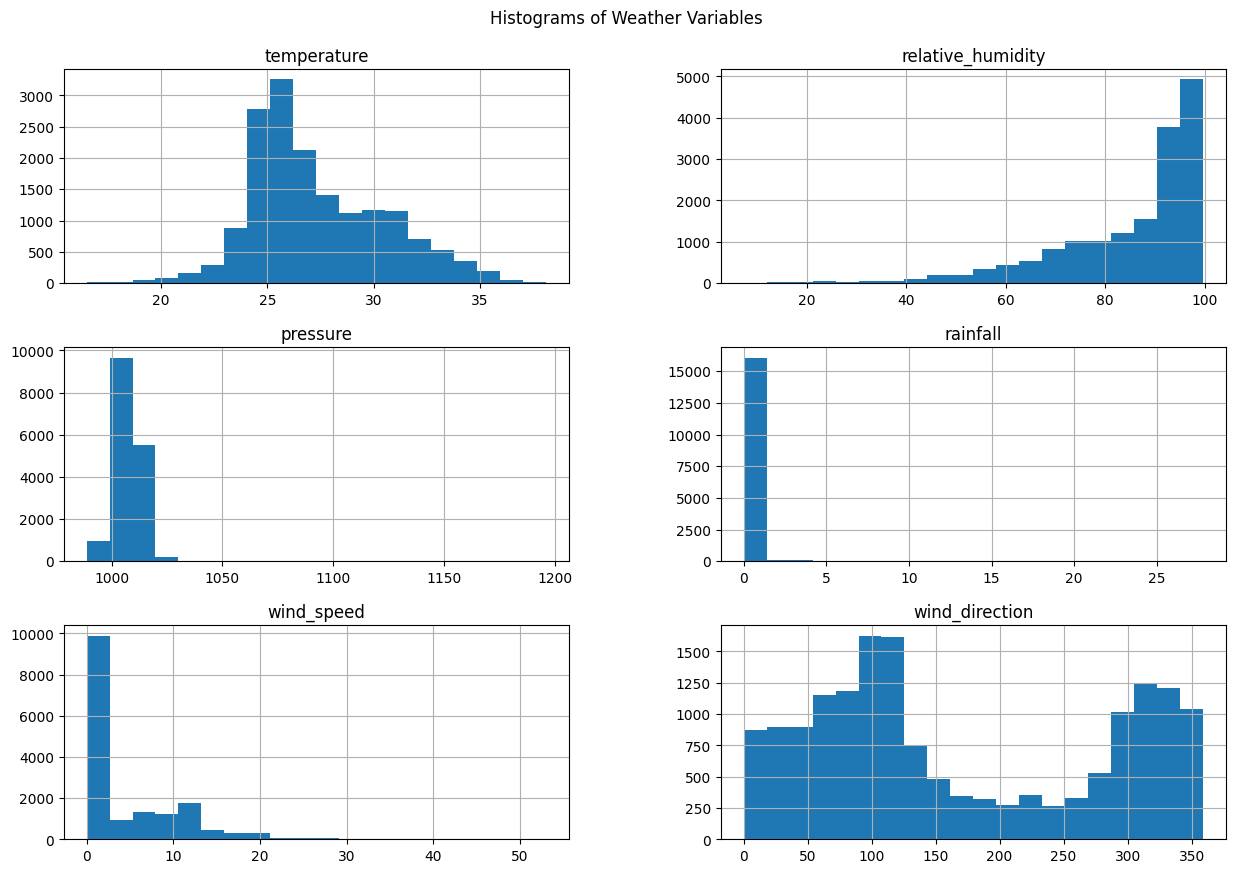

In [21]:
import matplotlib.pyplot as plt

# Plot histograms for each variable
df1.hist(figsize=(15, 10), bins=20)
plt.suptitle('Histograms of Weather Variables', y=0.94)
plt.show()
